In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from astropy.io import fits
from astropy.wcs import WCS

import healpy as hp
from astropy_healpix import HEALPix
from astropy.coordinates import FK5

from tqdm import tqdm_notebook as tqdm

from scipy.stats.mstats import mquantiles

In [17]:
fontScale = 16
params = {'axes.labelsize': fontScale,
        'axes.titlesize': fontScale,
        'axes.grid': False,
        'axes.linewidth': 2,
        'font.size': fontScale,
        'legend.fontsize': fontScale,
        'xtick.labelsize': fontScale,
        'ytick.labelsize': fontScale,
#         'font.weight': 450,
#         'axes.labelweight': 450,
        'xtick.major.size': 4,
        'xtick.major.width': 1.2,
        'xtick.minor.size': 3,
        'xtick.minor.width': 1.2,
        'ytick.major.size': 4,
        'ytick.major.width': 1.2,
        'ytick.minor.size': 3,
        'ytick.minor.width': 1.2,
        #'axes.facecolor': 'white',
        #'savefig.frameon': True # axes background color
}
# rc('text', usetex=False)
plt.rcParams.update(params)

Load q_PAH map from Planck and mask pixels below 3sigma (assumes you have downloaded the map from the Planck Legacy Archive)

In [2]:
qpah_file = 'COM_CompMap_Dust-DL07-Parameters_2048_R2.00.fits'
qpah_gal = hp.read_map(qpah_file, verbose=False, field=2)
qpah_gal_err = hp.read_map(qpah_file, verbose=False, field=3)
qpah_gal[qpah_gal < qpah_gal_err * 3.] = np.nan

/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


In [3]:
def change_coord(m, coord):
    """ Change coordinates of a HEALPIX map

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

Change q_PAH map from Galactic to Equatorial coordinates (to match f_CNM map later)

In [4]:
qpah = change_coord(qpah_gal, ['G', 'C'])

Load f_CNM map and mask pixels below Galactic latitude of 30 (if you need access to map ask Claire!)

In [5]:
fcnm_hpx = hp.read_map('fcnm_hi4pi_hpx.fits')

blimit = 30.
hpc = HEALPix(nside=1024, order='RING', frame=FK5())
hpc_coords = hpc.healpix_to_skycoord([np.arange(len(fcnm_hpx))])
lats = hpc_coords.galactic.b.degree
spots = np.squeeze(np.abs(lats)<blimit)
fcnm_hpx[spots] = np.nan

/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


Show q_PAH and f_CNM maps

/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will 

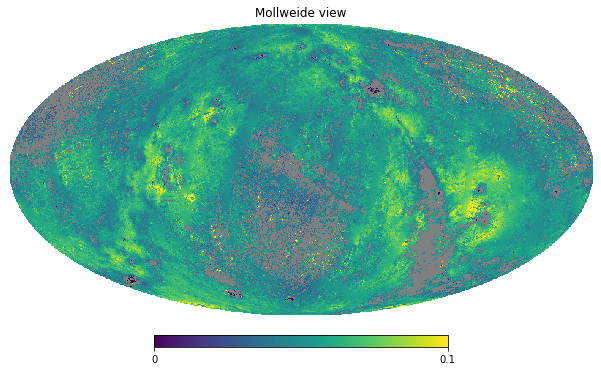

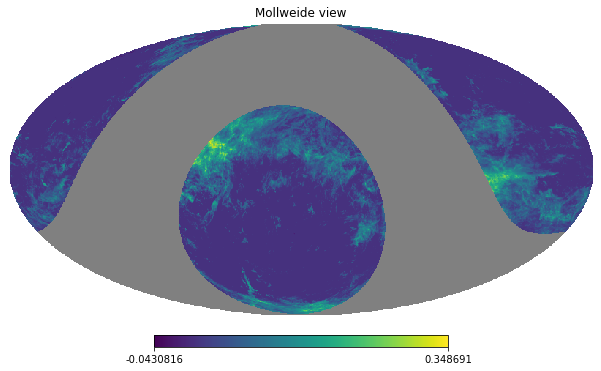

In [6]:
hp.mollview(qpah)

hp.mollview(fcnm_hpx)

Degrade both maps to same nside

In [7]:
nside_set = 512

# Degrade fcnm map:
fcnm_hpx_ud = hp.ud_grade(fcnm_hpx, nside_set, order_in='RING')
    
# Degrade Planck map:
qpah_ud = hp.ud_grade(qpah, nside_set, order_in='RING')

Define functions for bootstrap resampling and generating block indices

In [8]:
def bootstrap_resample(xlist, n=None):
    if n == None:
        n = len(xlist)
    resample_i = np.floor(np.random.rand(n)*len(xlist)).astype(int)

    xlist_resample = xlist[resample_i]
    return xlist_resample


In [9]:
def create_block_inds(n_ra, n_side):
    """ Based on the shape of a healpix map, generate indices for a number
    of blocks spaced in Right Ascension (RA)

    Parameters
    ----------
    n_ra : (int) number of RA blocks
    n_side : size of map
    
    Returns
    -------
    block_inds : list of indices corresponding to blocks
    """
    
    # Compute number of pixels from nside
    n_pix = hp.nside2npix(n_side)
    full_inds = np.arange(0,n_pix)

    # Generate bins according to number of RA bins
    edges = np.linspace(0, n_pix, n_ra+1)

    # Loop through and populate list of indices    
    block_inds = []
    for k in range(n_ra):
        inds = (full_inds >= edges[k]) & (full_inds < edges[k+1])
        block_inds.append(inds)

    return block_inds

Check that the block bootstrapping is working well (plot maps of each block)

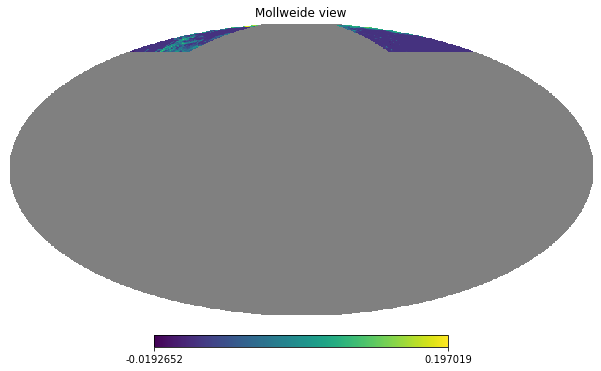

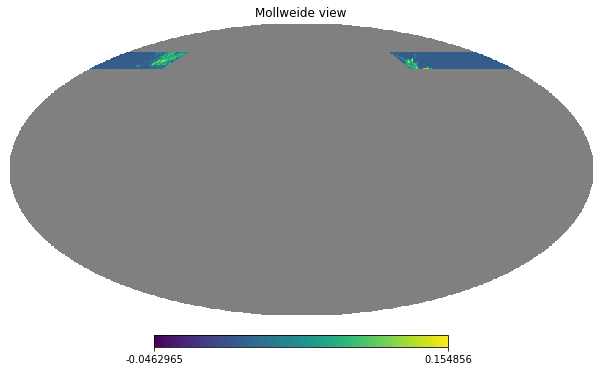

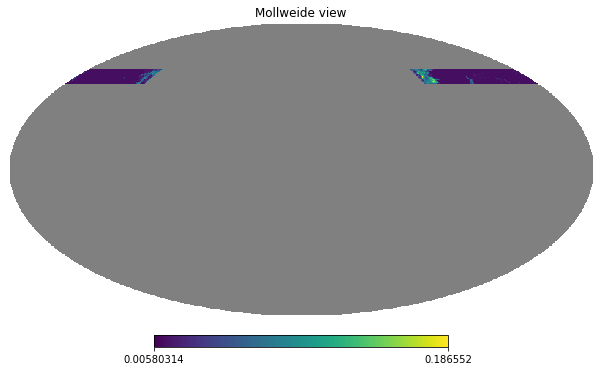

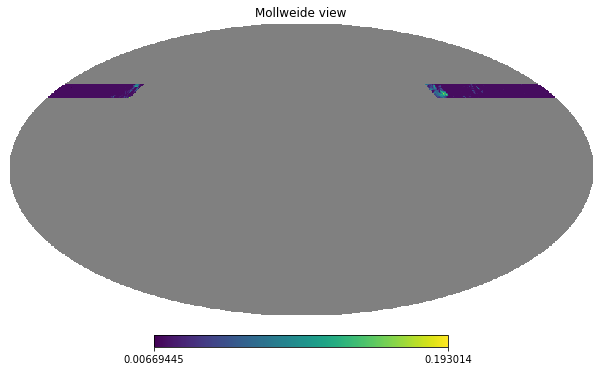

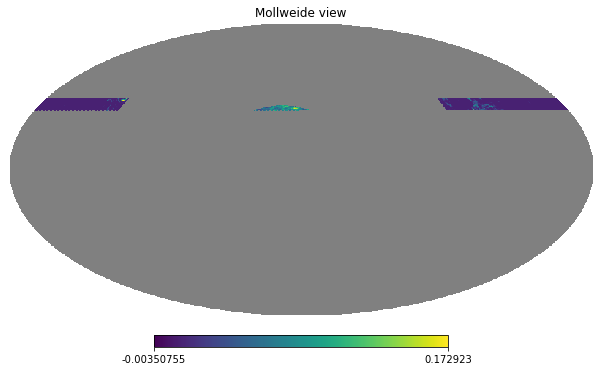

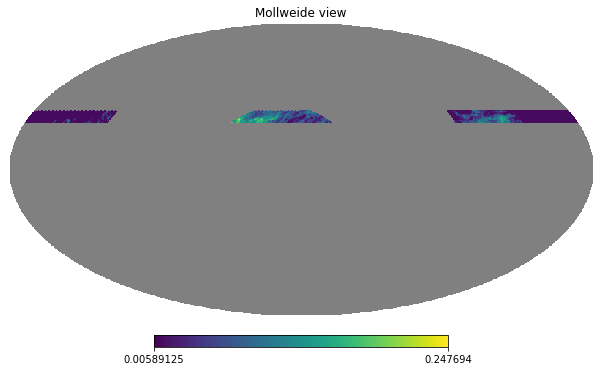

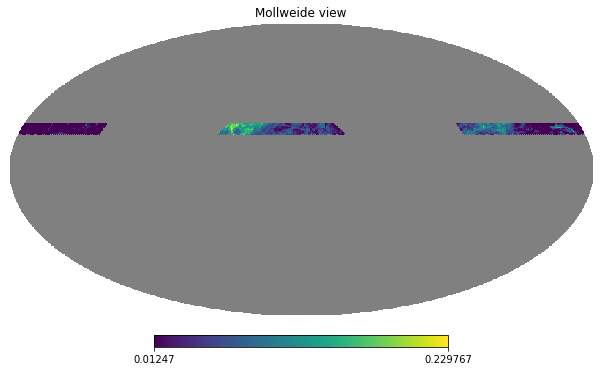

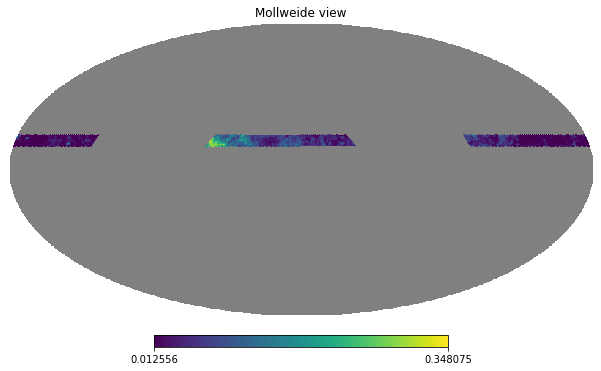

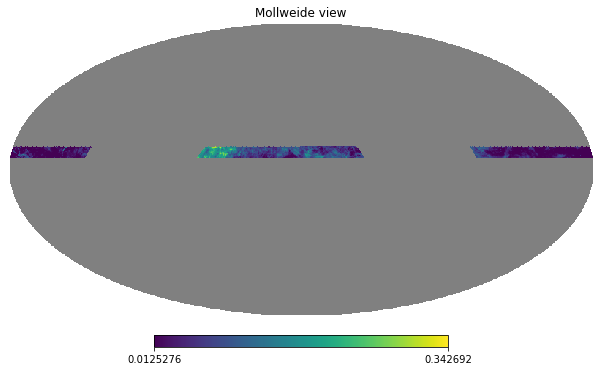

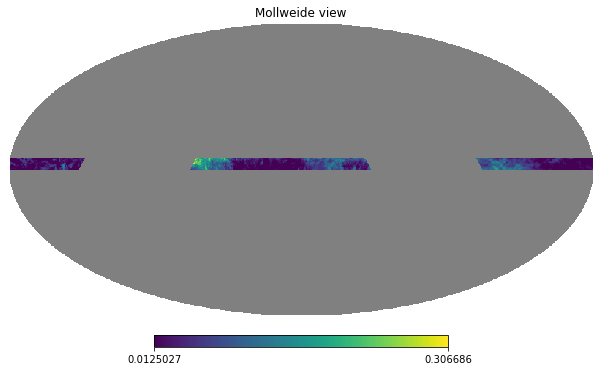

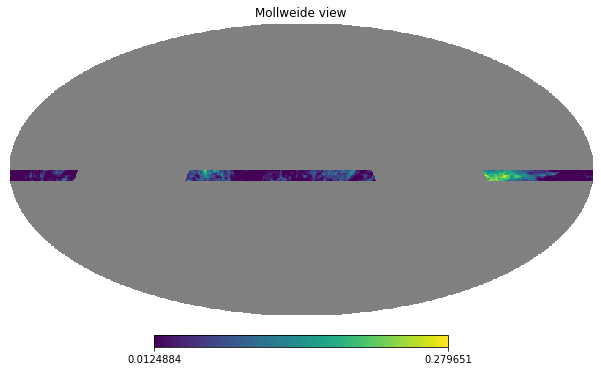

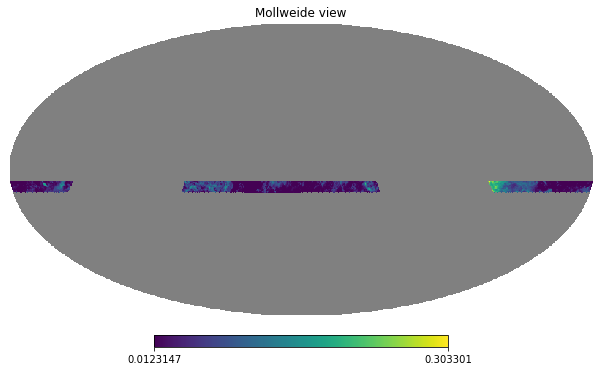

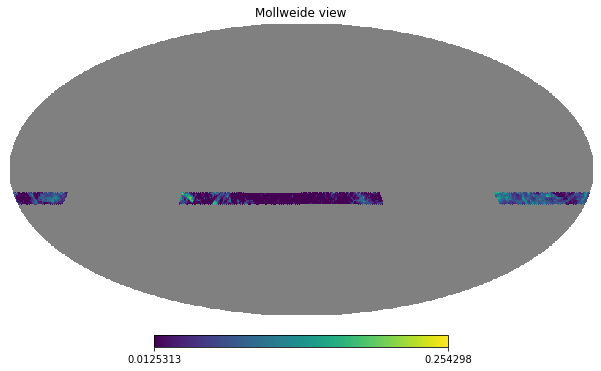

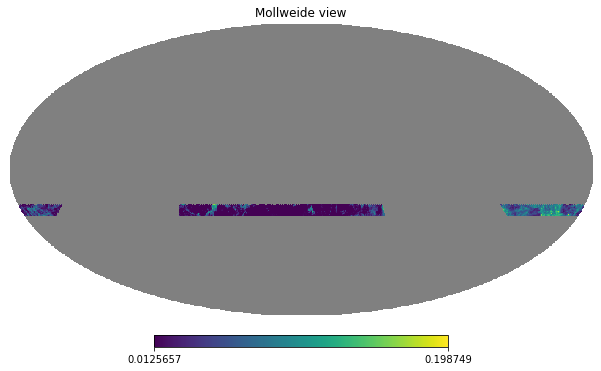

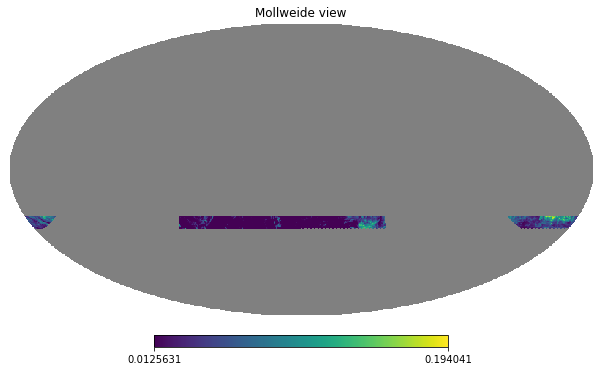

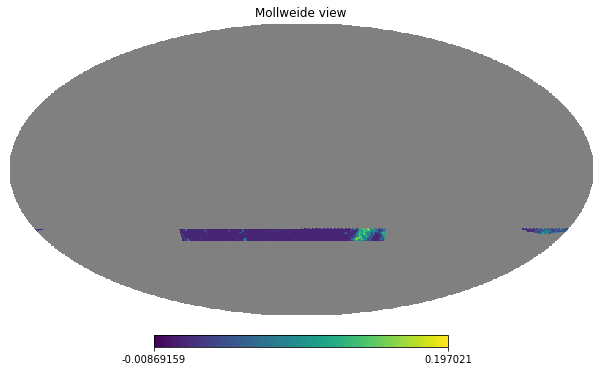

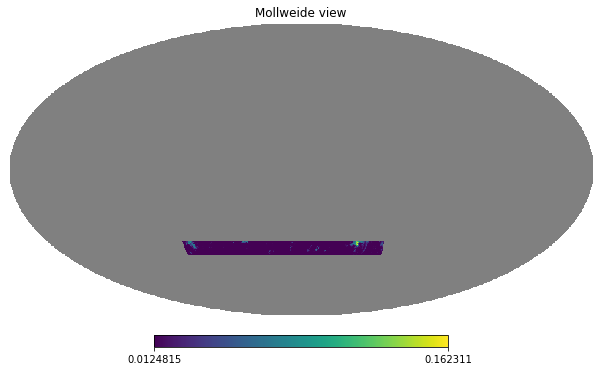

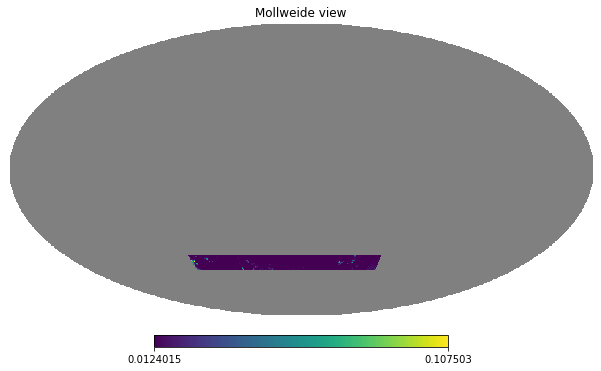

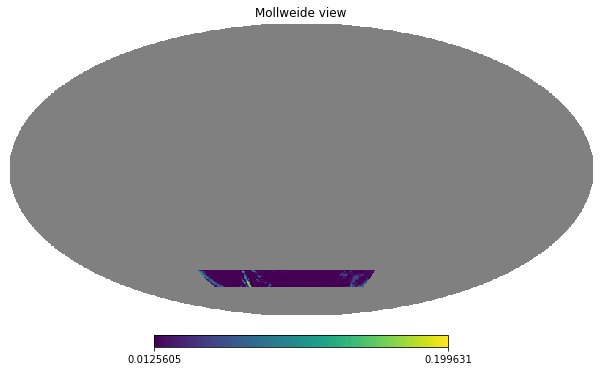

In [10]:
# Pick number of bins
n_ra = 20

# Extract block bootstrap indices
block_inds = create_block_inds(n_ra, nside_set)
block_inds = np.array(block_inds)

for i in range(n_ra-1): 
    ids_samp = block_inds[i]
    
    fcnm_sub = fcnm_hpx_ud.copy()
    fcnm_sub[~ids_samp] = np.nan
    
    hp.mollview(fcnm_sub)

The following function will plots cumulative distribution function of q_PAH in increasing bins of f_CNM

In [11]:
def cdfhist(arr, bins):
    """ Compute normalized cumulative distribution function from array and bins
    """
    fh = np.histogram(arr, bins=bins, density=True)
    fh = fh[0] / np.sum(fh[0])
    fh = np.cumsum(fh)
    return fh

In [12]:
def plot_block_boot_cdf(qpah_edges, fcnm_edges, qpah_map, fcnm_map, n_boot, n_ra, ax):
    """ Plot CDFs of q_PAH for increasing bins of f_CNM, with uncertainty ranges computed
    by block bootstrapping the sky in RA

    Parameters
    ----------
    qpah_edges : bin edges for q_PAH
    fcnm_edges : bin edges for f_CNM
    qpah_map : q_PAH HEALPix map 
    fcnm_map : f_CNM HEALPix map 
    n_boot : number of bootstrap trials
    n_ra : number of RA blocks
    ax : axis instance to use
    """
    
    # compute number of bins from the bin edges, generate colors to cycle through
    n_qpah_bins = len(qpah_edges)-1
    n_fcnm_bins = len(fcnm_edges)-1
    color=iter(cm.magma_r(np.linspace(0.2,0.8,n_fcnm_bins)))

    
    # Compute RA block and their indices
    block_inds = create_block_inds(n_ra, nside_set)
    block_inds = np.array(block_inds)
    block_inds_ids = np.arange(n_ra)

    # Loop through bins of increasing f_CNM
    for j in tqdm(range(n_fcnm_bins)):
    
        # Loop through number of bootstrap trials and generate list of CDFs
        qpah_hist_all = []
        for k in range(n_boot):
            # First make dummy array of NaNs in the shape of the qpah and fcnm maps
            qpah_temp = np.empty_like(qpah_map)
            fcnm_temp = np.empty_like(fcnm_map)
            qpah_temp[:] = np.nan
            fcnm_temp[:] = np.nan

            # Bootstrap resample the indices corresponding to the RA blocks
            block_inds_sel = bootstrap_resample(block_inds_ids)
            
            # Loop through the blocks and fill in the dummy maps with data corresponding to the selected blocks
            for i in range(n_ra-1): 
                ids_samp = block_inds[block_inds_sel[i]]

                qpah_temp[ids_samp] = qpah_map[ids_samp]
                fcnm_temp[ids_samp] = fcnm_map[ids_samp]

            # Compute CDFs of q_PAH from the selected RA blocks and which fall in the current f_CNM bin
            samp_spots = ~np.isnan(qpah_temp)  & (fcnm_temp > fcnm_edges[j]) & (fcnm_temp < fcnm_edges[j+1])
            qpah_hist = cdfhist(qpah_temp[samp_spots], qpah_bins)  
            
            # Dump CDF list in
            qpah_hist_all = qpah_hist_all + [np.array(qpah_hist)]

            
        qpah_hist_all = np.transpose(qpah_hist_all)

        qmin = np.zeros(n_qpah_bins)
        qmax = np.zeros(n_qpah_bins)
        qfull = np.zeros(n_qpah_bins)
                        
        for t in range(n_qpah_bins):
            qmin[t] = np.percentile(qpah_hist_all[t],16)
            qmax[t] = np.percentile(qpah_hist_all[t],84)
            qfull[t] = np.percentile(qpah_hist_all[t],50)
        
        # Plot CDF ranges (16th through 84th percentile)
        bincolor = next(color)   
        qpah_mids = (qpah_edges[1:] + qpah_edges[0:-1]) / 2.
        ax.fill_between(qpah_mids, qmin, qmax, color=bincolor, alpha=0.2)

        ax.plot(qpah_mids, qfull, color=bincolor, zorder=2, label=str(np.int(fcnm_edges[j]*1000.)/1000.)+r'$\leq f_{\rm CNM} <$'+str(np.int(fcnm_edges[j+1]*1000.)/1000.))


Plot the CDFs 

[0.0128     0.0174595  0.03671304 0.06211898 0.09277553 0.35626805]


<ipython-input-12-c516019022f3>:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j in tqdm(range(n_fcnm_bins)):


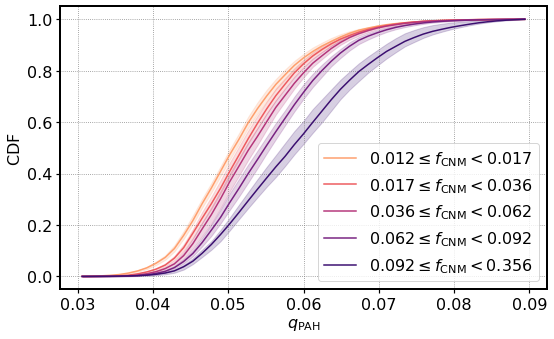

In [18]:
fig = plt.figure(0,[8,5])
ax = plt.subplot(111)

qpah_bins = np.linspace(0.03,0.09,50)
fcnm_hpx_arr = fcnm_hpx_ud[(fcnm_hpx_ud>0.0128) & (~np.isnan(fcnm_hpx_ud))]
fcnm_bins = mquantiles(fcnm_hpx_arr, np.arange(6)/5)
print(fcnm_bins)

# using small numbers here just to make the computation fast!
n_boot = 100
n_ra = 20 
plot_block_boot_cdf(qpah_bins, fcnm_bins, qpah_ud, fcnm_hpx_ud, n_boot, n_ra, ax)

ax.set_xlabel(r'$q_{\rm PAH}$')
ax.grid(ls='dotted', color='grey') 
ax.set_ylabel(r'$\rm CDF$')

ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('fcnm_qpah_cdf.pdf', format='pdf')

In [19]:
# check fcnm bin sizes
for k in range(len(fcnm_bins)-1):
    print(len(fcnm_hpx_ud[(fcnm_hpx_ud>fcnm_bins[k]) & (fcnm_hpx_ud<=fcnm_bins[k+1])]))

172477
172478
172479
172478
172478


In [15]:
fcnm_hpx_ud2 = fcnm_hpx_ud.copy()
fcnm_hpx_ud2[fcnm_hpx_ud2<0.0128] = np.nan

/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will 

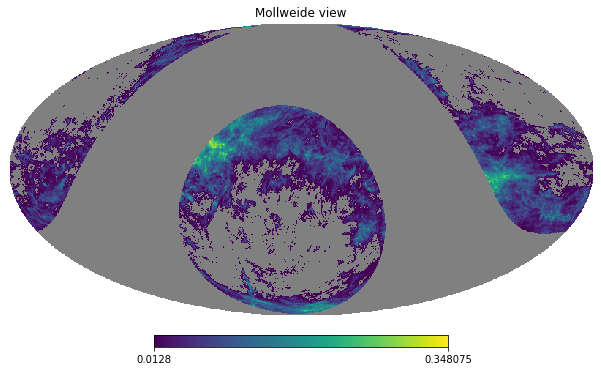

In [16]:
hp.mollview(fcnm_hpx_ud2)